<a href="https://colab.research.google.com/github/bala-baskar/aiml_tech_courses/blob/main/pytorch/NN_exercise_tab_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Titanic survivorship prediction - Classification

In [40]:
# Load Titanic dataset
data = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
# Select relevant features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

data = data[features + [target]].dropna()
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [42]:
# Encode categorical features
le_sex = LabelEncoder()
data['Sex'] = le_sex.fit_transform(data['Sex'])

le_embarked = LabelEncoder()
data['Embarked'] = le_embarked.fit_transform(data['Embarked'])
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,22.0,1,0,7.2500,2,0
1,1,0,38.0,1,0,71.2833,0,1
2,3,0,26.0,0,0,7.9250,2,1
3,1,0,35.0,1,0,53.1000,2,1
4,3,1,35.0,0,0,8.0500,2,0


In [43]:
# Split data into features and target
X = data[features]
y = data[target].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(569, 7) (143, 7) (569,) (143,)


In [44]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
472,2,0,33.0,1,2,27.7500,2
432,2,0,42.0,1,0,26.0000,2
666,2,1,25.0,0,0,13.0000,2
30,1,1,40.0,0,0,27.7208,0
291,1,0,19.0,1,0,91.0792,0


In [45]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
# Convert to tensors
X_tr_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_train, dtype=torch.float32)
X_ts_tensor = torch.tensor(X_test, dtype=torch.float32)
y_ts_tensor = torch.tensor(y_test, dtype=torch.float32)

In [47]:
# Convert to DataLoader
train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(X_ts_tensor, y_ts_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
class LogisticRegressor(nn.Module):
  def __init__(self,input_shape, output_shape):
    super().__init__()
    self.fc1 = nn.Linear(input_shape,output_shape)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    return self.sigmoid(self.fc1(x))

In [49]:
torch.manual_seed(123)
lr_model = LogisticRegressor(input_shape=len(X.columns),output_shape=1)
print(lr_model.state_dict())
loss_fn = nn.BCELoss()
optimizer = optim.SGD(lr_model.parameters(), lr=0.01)

OrderedDict([('fc1.weight', tensor([[-0.1541,  0.0125, -0.1877,  0.1425, -0.3220,  0.2771, -0.2747]])), ('fc1.bias', tensor([-0.3005]))])


In [50]:
# Check forward pass output
lr_model(train_dataset[0][0])

tensor([0.2661], grad_fn=<SigmoidBackward0>)

In [51]:
# Train the model
epochs = 100
for epoch in range(epochs):
    lr_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = lr_model(X_batch).squeeze()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluate the model
lr_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = lr_model(X_batch).squeeze()
        y_pred = (y_pred > 0.5).float()
        correct += (y_pred == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Epoch 10/100, Loss: 0.5389
Epoch 20/100, Loss: 0.4942
Epoch 30/100, Loss: 0.4723
Epoch 40/100, Loss: 0.4585
Epoch 50/100, Loss: 0.4498
Epoch 60/100, Loss: 0.4448
Epoch 70/100, Loss: 0.4441
Epoch 80/100, Loss: 0.4407
Epoch 90/100, Loss: 0.4388
Epoch 100/100, Loss: 0.4380
Test Accuracy: 0.7902


### Boston HousingPrice prediction - Regression

 Variables in order:
 1. CRIM     per capita crime rate by town
 2. ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 3. INDUS    proportion of non-retail business acres per town
 4. CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 5. NOX      nitric oxides concentration (parts per 10 million)
 6. RM       average number of rooms per dwelling
 7. AGE      proportion of owner-occupied units built prior to 1940
 8. DIS      weighted distances to five Boston employment centres
 9. RAD      index of accessibility to radial highways
 10.TAX      full-value property-tax rate per $10,000  
 11. PTRATIO pupil-teacher ratio by town    
 12. B       1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town  
 13. LSTAT   % lower status of the population
 14. MEDV    Median value of owner-occupied homes in $1000's

In [52]:
data = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/refs/heads/master/BostonHousing.csv")
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [53]:
target = 'medv'
X = data.drop(target,axis=1)
y = data[target].values
print(X.shape, y.shape)

(506, 13) (506,)


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=12)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(404, 13) (102, 13) (404,) (102,)


In [55]:
X_tr_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_ts_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_tr_tensor = torch.tensor(y_train, dtype=torch.float32)
y_ts_tensor = torch.tensor(y_test, dtype=torch.float32)

In [56]:
train_data = TensorDataset(X_tr_tensor,y_tr_tensor)
test_data = TensorDataset(X_ts_tensor, y_ts_tensor)
train_dataset = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataset = DataLoader(test_data,batch_size=32)

In [57]:
class LinearRegressor(nn.Module):
  def __init__(self,input_shape,output_shape):
    super().__init__()
    self.fc1 = nn.Linear(in_features=input_shape,
                         out_features=8)
    self.fc2 = nn.Linear(in_features=8,
                         out_features=output_shape)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.relu(self.fc2(self.relu(self.fc1(x))))

In [58]:
model = LinearRegressor(input_shape=len(X_train.columns),output_shape=1)
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.2142,  0.0823, -0.1250,  0.1746, -0.1900, -0.1616, -0.1337,  0.1200,
                        0.0382,  0.1765,  0.1823,  0.0162,  0.1617],
                      [-0.2004, -0.2651, -0.2260,  0.1531,  0.2550, -0.0767,  0.1535, -0.1982,
                       -0.0052, -0.0017, -0.0803, -0.1344,  0.1301],
                      [-0.0242, -0.0550,  0.1927, -0.2106,  0.1811,  0.2463, -0.1704, -0.2628,
                        0.0386, -0.2109,  0.1160, -0.2212, -0.2165],
                      [ 0.0750, -0.0711, -0.2455,  0.1082,  0.0980,  0.0374,  0.1812, -0.1114,
                        0.2531, -0.2114,  0.2501,  0.2061, -0.2467],
                      [-0.0246, -0.1492,  0.2729, -0.0116,  0.1634,  0.2398, -0.2139,  0.1686,
                       -0.2413, -0.0749, -0.1118, -0.2594, -0.2612],
                      [-0.2674, -0.2145, -0.1550, -0.0914,  0.1552, -0.0446, -0.2746, -0.2015,
                        0.1990, -0.2706, -0.1364, -0.2510

In [59]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [60]:
epochs = 500
train_loss, test_loss = [], []
for epoch in range(epochs):
  total_tr_loss = 0
  for X_batch, y_batch in train_dataset:
    model.train()
    y_pred = model(X_batch).squeeze()
    loss = loss_fn(y_pred,y_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_tr_loss += loss

  if (epoch+1) % 10 == 0:
    model.eval()
    total_loss = 0
    with torch.no_grad():
      for X_batch, y_batch in test_dataset:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred,y_batch)
        total_loss += loss

    print(f"Train epoch {epoch}/{epochs}: Train Loss: {total_tr_loss/len(train_dataset)}, Test loss {total_loss/len(test_dataset)}")
    train_loss.append((total_tr_loss/len(train_dataset)).detach().numpy().item())
    test_loss.append((total_loss/len(test_dataset)).detach().numpy().item())

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train epoch 9/500: Train Loss: 63.073001861572266, Test loss 112.20441436767578
Train epoch 19/500: Train Loss: 56.498836517333984, Test loss 109.66299438476562
Train epoch 29/500: Train Loss: 50.11301040649414, Test loss 107.83699035644531
Train epoch 39/500: Train Loss: 47.393310546875, Test loss 104.57988739013672
Train epoch 49/500: Train Loss: 43.609046936035156, Test loss 105.6439437866211
Train epoch 59/500: Train Loss: 40.13156509399414, Test loss 105.43421936035156
Train epoch 69/500: Train Loss: 38.51480484008789, Test loss 106.90252685546875
Train epoch 79/500: Train Loss: 36.831607818603516, Test loss 109.03104400634766
Train epoch 89/500: Train Loss: 33.82253646850586, Test loss 111.64148712158203
Train epoch 99/500: Train Loss: 34.172672271728516, Test loss 114.82322692871094
Train epoch 109/500: Train Loss: 31.837617874145508, Test loss 114.64920806884766
Train epoch 119/500: Train Loss: 32.483280181884766, Test loss 117.05238342285156
Train epoch 129/500: Train Loss: 31

In [61]:
y_pred = model(torch.tensor(X_test.to_numpy(),dtype=torch.float32)).squeeze().detach().numpy()
y_pred

array([25.67785  , 19.738045 ,  6.8148947, 30.793528 , 34.169796 ,
       20.210371 , 22.596037 , 38.3479   , 32.79654  , 27.664255 ,
       20.553572 , 21.204996 , 21.449888 , 22.380472 , 33.412113 ,
       41.837776 , 20.760952 , 28.11741  , 27.07632  , 27.342417 ,
       33.19632  , 11.108779 , 22.55061  , 13.349759 , 27.054735 ,
       18.477476 , 21.399183 , 10.997657 , 28.591455 , 38.51142  ,
       27.659855 , 28.752361 , 15.535565 , 31.689837 , 40.975487 ,
       16.31965  , 21.912865 , 38.649967 , 14.750226 , 26.630121 ,
       14.739877 , 24.520903 , 18.557161 , 35.841442 , 15.559554 ,
       18.588388 , 21.322708 , 23.643694 , 35.363285 , 22.38772  ,
       29.08035  , 21.45772  ,  9.970986 , 27.828932 , 16.556465 ,
       16.837063 , 27.585543 , 16.47574  , 15.773526 , 20.192049 ,
       18.040342 , 30.059925 , 21.572517 , 17.631504 , 18.732443 ,
       26.61233  , 28.233456 , 12.641517 , 26.013334 , 35.50544  ,
       13.518235 , 11.77065  , 21.96687  , 23.057753 , 20.0127

In [62]:
y_pred.shape, y_test.shape

((102,), (102,))

In [63]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test,y_pred)

0.1976465705531851

<Axes: >

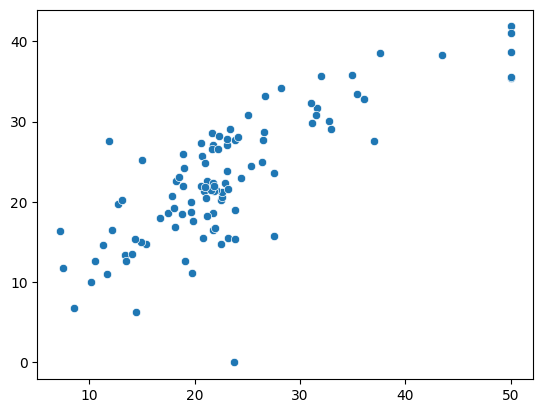

In [64]:
import seaborn as sns
sns.scatterplot(x=y_test,y=y_pred)

<Axes: >

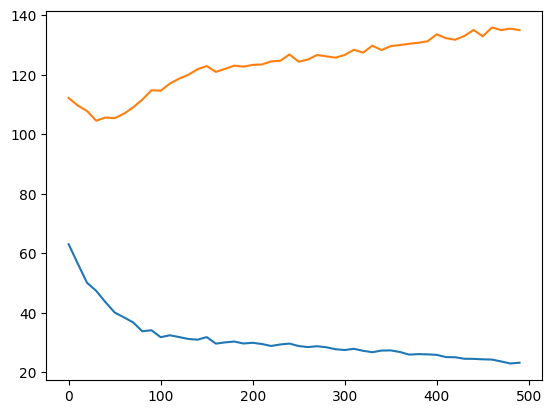

In [65]:
# Train loss vs Test loss
sns.lineplot(x=range(0,epochs,10),y=train_loss)
sns.lineplot(x=range(0,epochs,10),y=test_loss)